# Final Results

Authors: Brian R. Mullen, Sero Toriano Parel, Revati Jadhav, Carrie Clark, Philip Nelson

Date: 2025-11-01

Python notebook re: Clean, readable notebook showing final model training, evaluation, and plots; must produce all metrics/visuals shown in the presentation

Input(s):
- `../data/processed/train_calib_full.csv`: training/calibration split with all 160 features for full-feature model experiments
- `../data/processed/test_holdout_full.csv`: test holdout split with all 160 features for full-feature model experiments
- `../results/feature_selection.csv`: results of feature selection
- `..results/model_comparison.csv`: tabular record of model family, hyperparameters, and KPI scores

Main output(s):
- `../results/final/` folder: saved KPI tables, plots
- `../artifacts/final_model.pkl` (or `.joblib`): serialized final pipeline/model

## Setup

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
import os
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

# Global configuration
RANDOM_STATE = 13
sns.set_palette("viridis")

# Output directories
Path("../artifacts").mkdir(exist_ok=True)
Path("../results/final").mkdir(exist_ok=True)

### Load data

In [2]:
# Load training & test data
train_df = pd.read_csv("../data/processed/train_calib_selected.csv")
test_df = pd.read_csv("../data/processed/test_holdout_selected.csv")

# Load results logs
model_comparison = pd.read_csv("../results/model_comparison.csv")
feature_selection_log = pd.read_csv("../results/feature_selection.csv")

# Inspect
print(f"Training data: {train_df.shape}")
print(f"Test data: {test_df.shape}")
print(f"Model comparison records: {model_comparison.shape[0]} models ({', '.join(model_comparison['Model'].tolist())})")
print(f"Feature selection records: {feature_selection_log.shape[0]} features")

Training data: (108187, 40)
Test data: (27112, 40)
Model comparison records: 7 models (Logit_L2, Logit_Weighted_L2, Logit_All_L2, Logit_Weighted_All_L2, RandomForest, DecisionTree, DummyClassifier)
Feature selection records: 160 features


In [3]:
# See final selected features
final_features = feature_selection_log[feature_selection_log['in_final_set'] == 1]
print(f"Number of final selected features: {len(final_features)}")
print("Final feature list:")
print(final_features[['feature', 'channel', 'category', 'rank']].to_string())

Number of final selected features: 37
Final feature list:
                 feature channel category  rank
123             ch05_rms    ch05      RMS     1
124             ch04_rms    ch04      RMS     2
125          ch03_maxabs    ch03      Max     7
126             ch06_rms    ch06      RMS     9
127             ch10_rms    ch10      RMS    12
128             ch07_mav    ch07      MAV    19
129             ch15_rms    ch15      RMS    22
130             ch14_rms    ch14      RMS    23
131             ch13_rms    ch13      RMS    24
132             ch08_rms    ch08      RMS    26
133             ch12_rms    ch12      RMS    28
134             ch02_rms    ch02      RMS    29
135          ch09_maxabs    ch09      Max    31
136  ch05_thresh2-events    ch05   Thresh    37
137    ch11_fft-maxpower    ch11      FFT    38
138    ch09_fft-maxpower    ch09      FFT    39
139    ch03_fft-maxpower    ch03      FFT    40
140  ch04_thresh2-events    ch04   Thresh    42
141          ch11_maxabs    ch

In [4]:
# # Check columns available
# print("Available columns:", feature_selection_log.columns.tolist())

# # selection indicator column
# selected_count = feature_selection_log['selected'].sum()
# print(f"Number of selected features: {selected_count}")

# # Get selected feature names
# selected_features = feature_selection_log[feature_selection_log['selected'] == True]['feature'].tolist()
# print(f"Selected features: {selected_features}")

# # features ranked by importance:
# # Features w/ rank <= threshold might be selected
# threshold = len(final_features)  # Or adjust manually based on selected 
# selected_features = feature_selection_log[feature_selection_log['rank'] <= threshold]['feature'].tolist()
# print(f"Top {len(selected_features)} selected features by rank")

### Define final model hyperparameters

In [5]:
# Define final model config
FINAL_MODEL_NAME = 'Logit_L2'
FINAL_MODEL_PARAMS = {
    'solver': 'lbfgs',
    'max_iter': 1000,
    'random_state': RANDOM_STATE,
}

print("Final model configuration:")
print(f"- Model: {FINAL_MODEL_NAME}")
print(f"- Parameters: {FINAL_MODEL_PARAMS}")

Final model configuration:
- Model: Logit_L2
- Parameters: {'solver': 'lbfgs', 'max_iter': 1000, 'random_state': 13}


## Model selection justification

### [Figure] Cross-validation model performance comparison (F1 Macro)

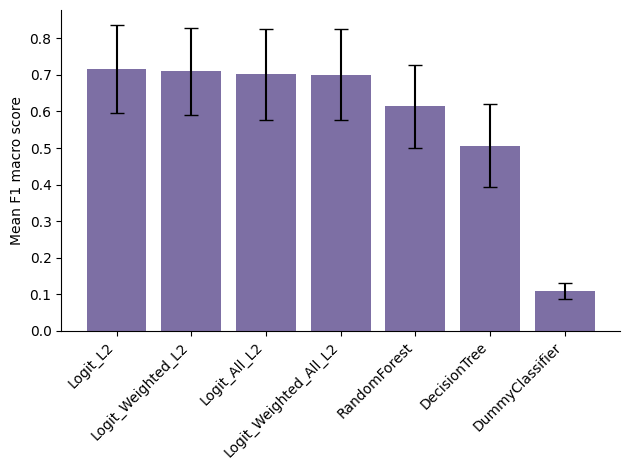

In [6]:
# Visualization
model_order = model_comparison.sort_values('Mean_F1_Macro', ascending=False)['Model'].tolist()

# Barplot
bars = plt.bar(range(len(model_order)), 
               [model_comparison.loc[model_comparison['Model'] == m, 'Mean_F1_Macro'].iloc[0] for m in model_order],
               yerr=[model_comparison.loc[model_comparison['Model'] == m, 'Std_F1_Macro'].iloc[0] for m in model_order],
               capsize=5, alpha=0.7)

plt.ylabel('Mean F1 macro score')
plt.xticks(range(len(model_order)), model_order, rotation=45, ha='right')
plt.grid(False)
plt.gca().spines['top'].set_visible(False) # Remove top border
plt.gca().spines['right'].set_visible(False) # Remove right border

plt.tight_layout()
plt.savefig("../results/final/model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

**Figure: Model performance comparison.** Cross-validation F1 macro scores (mean ± SD) for within-user personalization (100 users, K=5). Logistic regression with L2 regularization using selected features (Logit_L2) achieved the best performance (F1 = 0.7164 ± 0.1194, accuracy = 0.7340 ± 0.1195), outperforming full-feature models. Selected-feature linear models (37 features) outperform full-feature models (160 features) and ensemble methods, demonstrating that personalized feature selection effectively captures user-specific signal patterns.

In [7]:
# Model performance comparison 
# Create summary table for model performance
performance_summary = model_comparison[['Model', 'Mean_F1_Macro', 'Std_F1_Macro', 'Mean_Accuracy', 'Std_Accuracy']].copy()
performance_summary = performance_summary.round(4)
performance_summary['F1_Rank'] = performance_summary['Mean_F1_Macro'].rank(ascending=False).astype(int)
# performance_summary['Selected'] = performance_summary['Model'] == FINAL_MODEL_NAME

# Inspect
performance_summary

,Model,Mean_F1_Macro,Std_F1_Macro,Mean_Accuracy,Std_Accuracy,F1_Rank
0,Logit_L2,0.7164,0.1195,0.7340,0.1195,1
1,Logit_Weighted_L2,0.7098,0.1182,0.7289,0.1191,2
2,Logit_All_L2,0.7013,0.1239,0.7250,0.1257,3
3,Logit_Weighted_All_L2,0.7005,0.1246,0.7223,0.1263,4
4,RandomForest,0.6138,0.1139,0.6428,0.1196,5
5,DecisionTree,0.5063,0.1131,0.5471,0.1298,6
6,DummyClassifier,0.1086,0.0223,0.1465,0.0437,7


**Table: Model performance rankings.** Cross-validation results (100 users, K=5) reveal that selected-feature logistic regression models (`Logit_L2` and `Logit_Weighted_L2`) outperform full-feature linear models and ensemble methods, with the 37-feature model achieving superior generalization despite using 77% fewer features than the full 160-feature model.

## Final model training

### Train final pipeline on all training data

In [8]:
# Prepare training data
TARGET = 'gesture'
GROUP = 'user'
METADATA_COLS = [TARGET, GROUP, 'stage']

# Get feature columns (exclude metadata)
feature_cols = [col for col in train_df.columns if col not in METADATA_COLS]
X_train = train_df[feature_cols]
y_train_raw = train_df[TARGET]

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
class_names = le.classes_

# Verify
print(f"Training features: {X_train.shape}")
print(f"Classes: {class_names.tolist()}")

# Initialize & train final pipeline
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(**FINAL_MODEL_PARAMS))
])

# Run
final_pipeline.fit(X_train, y_train)

Training features: (108187, 37)
Classes: ['index_press', 'index_release', 'middle_press', 'middle_release', 'thumb_click', 'thumb_down', 'thumb_in', 'thumb_out', 'thumb_up']


,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


### Serialize final pipeline/model

In [9]:
# Save trained model
model_path = "../artifacts/final_model.joblib"
joblib.dump(final_pipeline, model_path)
print(f"Final model saved to: {model_path}")

# Also save label encoder
encoder_path = "../artifacts/label_encoder.joblib"
joblib.dump(le, encoder_path)
print(f"Label encoder saved to: {encoder_path}")

Final model saved to: ../artifacts/final_model.joblib
Label encoder saved to: ../artifacts/label_encoder.joblib


## Holdout evaluation and performance analysis

### Generate predictions and calculate KPIs

In [10]:
# Prep test data
X_test = test_df[feature_cols]
y_test_raw = test_df[TARGET]
y_test = le.transform(y_test_raw)

# Inspect
print(f"Test set: {X_test.shape}")
print(f"Test samples per class: {pd.Series(y_test_raw).value_counts().to_dict()}")

Test set: (27112, 37)
Test samples per class: {'middle_press': 4462, 'middle_release': 4458, 'index_press': 4453, 'index_release': 4425, 'thumb_out': 1964, 'thumb_in': 1941, 'thumb_up': 1937, 'thumb_down': 1885, 'thumb_click': 1587}


In [11]:
# Generate predictions 
y_pred = final_pipeline.predict(X_test)
y_pred_proba = final_pipeline.predict_proba(X_test)

### KPI summary

In [12]:
# Calculate KPI metrics
final_f1_macro = f1_score(y_test, y_pred, average='macro')
final_accuracy = accuracy_score(y_test, y_pred)
final_classification_error = 1 - final_accuracy

# Create & save metrics df
final_metrics_df = pd.DataFrame({
    'Metric': ['F1_Macro', 'Accuracy', 'Classification_Error_Rate'],
    'Value': [final_f1_macro, final_accuracy, final_classification_error],
    'Dataset': ['Holdout_Test'] * 3
})

# Save file
final_metrics_df.to_csv("../results/final/final_kpi_summary.csv", index=False)

# Inspect
final_metrics_df

,Metric,Value,Dataset
0,F1_Macro,0.397683,Holdout_Test
1,Accuracy,0.468722,Holdout_Test
2,Classification_Error_Rate,0.531278,Holdout_Test


**Table: Final KPIs on holdout set performance.** Evaluation on holdout test data using the selected 37-feature logistic regression model, establishing baseline performance for cross-user gesture recognition.

### [Figure] Holdout confusion matrix and error analysis

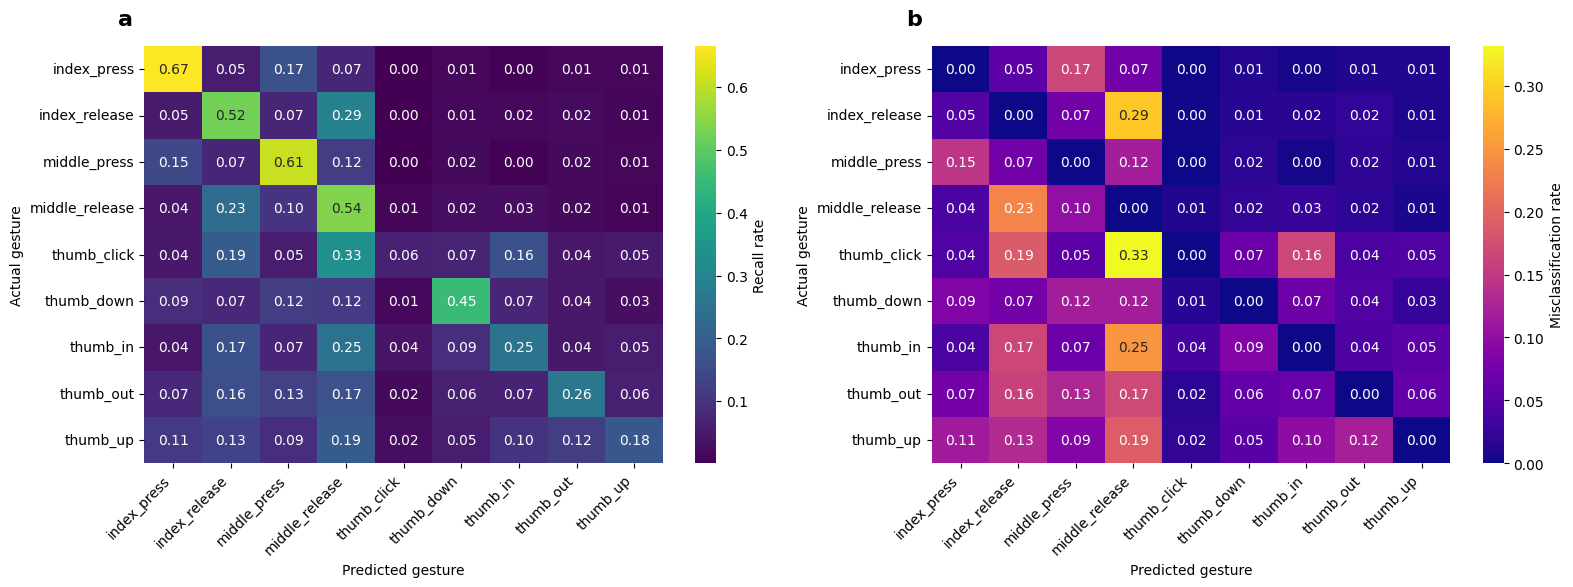

In [13]:
# Confusion Matrix Analysis
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Subplot: Normalized confusion matrix
heatmap1 = sns.heatmap(conf_mat_normalized, annot=True, fmt='.2f', cmap='viridis',
            xticklabels=class_names, yticklabels=class_names, ax=ax1,
            cbar_kws={'label': 'Recall rate'})
ax1.set_xlabel('Predicted gesture')
ax1.set_ylabel('Actual gesture')
ax1.text(-0.05, 1.05, 'a', transform=ax1.transAxes, fontsize=16, fontweight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')  # Rotate

# Subplot: Misclassification patterns
conf_mat_no_diag = conf_mat_normalized.copy()
np.fill_diagonal(conf_mat_no_diag, 0)

heatmap2 = sns.heatmap(conf_mat_no_diag, annot=True, fmt='.2f', cmap='plasma',
            xticklabels=class_names, yticklabels=class_names, ax=ax2,
            cbar_kws={'label': 'Misclassification rate'})
ax2.set_xlabel('Predicted gesture')
ax2.set_ylabel('Actual gesture')
ax2.text(-0.05, 1.05, 'b', transform=ax2.transAxes, fontsize=16, fontweight='bold')
# Rotate x-axis tick labels
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig("../results/final/confusion_matrix_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

**Figure: Confusion matrix analysis.** (a) Holdout test set performance showing recall rates, where diagonal performance shows user-specific gesture recognition patterns. (b) Systematic misclassification patterns showing cross-user generalization challenges, with persistent confusions between finger release gestures and directional thumb movements.

In [14]:
# Create confusion patterns df
confusion_data = []
for i, true_class in enumerate(class_names):
    for j, pred_class in enumerate(class_names):
        if i != j and conf_mat_normalized[i, j] > 0.1:
            confusion_data.append([true_class, pred_class, conf_mat_normalized[i, j], conf_mat[i, j]])

confusion_df = pd.DataFrame(confusion_data, 
                           columns=['True_Gesture', 'Predicted_Gesture', 'Confusion_Rate', 'Raw_Count']
                          ).sort_values('Confusion_Rate', ascending=False)

# print("Key systematic confusions (rate > 0.1):")
confusion_df

,True_Gesture,Predicted_Gesture,Confusion_Rate,Raw_Count
7,thumb_click,middle_release,0.331443,526
1,index_release,middle_release,0.293107,1297
12,thumb_in,middle_release,0.249356,484
4,middle_release,index_release,0.234186,1044
18,thumb_up,middle_release,0.191533,371
6,thumb_click,index_release,0.188406,299
15,thumb_out,middle_release,0.168534,331
11,thumb_in,index_release,0.166409,323
0,index_press,middle_press,0.165282,736
8,thumb_click,thumb_in,0.164461,261


**Table: Systematic gesture confusions with rates >10%.** Release gestures (i.e., `index_release`, `middle_release`) were the most confused targets across multiple thumb and finger movements, suggesting shared neuromuscular signatures.

## Model interpretation and diagnostics

### [Figure] Normalized feature importance

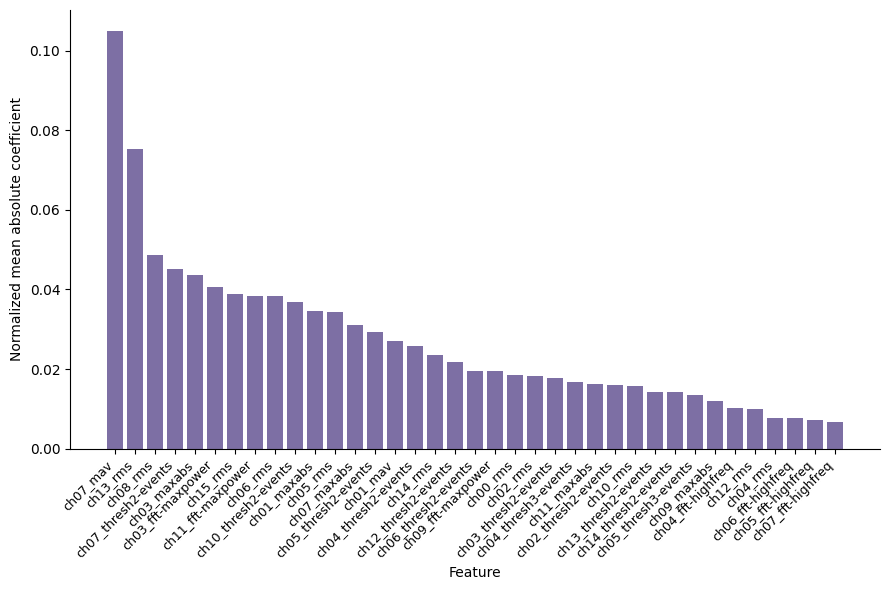

In [15]:
# Show ALL selected features
TOP_N_FEATURES = len(final_features)  # Show all selected feats

# Extract & visualize feature importance from final model
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': np.abs(final_pipeline.named_steps['clf'].coef_).mean(axis=0)
}).sort_values('importance', ascending=False)

# Normalize importance to sum to 1 for relative comparison
feature_importance['importance_normalized'] = feature_importance['importance'] / feature_importance['importance'].sum()

# Get all selected features
all_selected_features = feature_importance.head(TOP_N_FEATURES)

# Create fig
plt.figure(figsize=(9, 6))

bars = plt.bar(all_selected_features['feature'], all_selected_features['importance_normalized'], alpha=0.7)

# Remove borders & grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)  # Keep left spine for y-axis reference
plt.gca().spines['bottom'].set_visible(True)  # Keep bottom spine for x-axis reference
plt.grid(False)

plt.ylabel('Normalized mean absolute coefficient')
plt.xlabel('Feature')
# plt.title('Feature Importance: All 37 Selected Features')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=9)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.savefig("../results/final/feature_importance_all_37.png", dpi=300, bbox_inches='tight')
plt.show()

**Figure: Feature importance rankings of all 37 selected features.** All features from the feature selection process are shown with their normalized logistic regression coefficients. Root mean square (RMS) features dominate the top rankings. The distribution shows the relative contribution of each engineered feature to gesture discrimination in the final personalized model.

### [Figure] Per-user performance diagnostic swarm plot

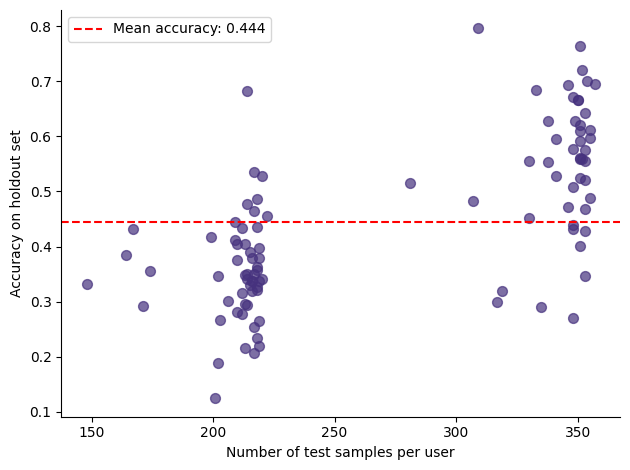

In [16]:
# Per-user performance on test set
user_performance = []
for user_id in test_df[GROUP].unique():
    user_mask = test_df[GROUP] == user_id
    if user_mask.sum() > 0:  # Ensure user has test samples
        user_accuracy = accuracy_score(y_test[user_mask], y_pred[user_mask])
        user_samples = user_mask.sum()
        user_performance.append({
            'User_ID': user_id,
            'Accuracy': user_accuracy,
            'Sample_Count': user_samples
        })

user_perf_df = pd.DataFrame(user_performance)

# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(user_perf_df['Sample_Count'], user_perf_df['Accuracy'], alpha=0.7, s=50)

# Remove all borders & grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.grid(False)

plt.xlabel('Number of test samples per user')
plt.ylabel('Accuracy on holdout set')

# Add summary stats
mean_acc = user_perf_df['Accuracy'].mean()
plt.axhline(y=mean_acc, color='red', linestyle='--', label=f'Mean accuracy: {mean_acc:.3f}')
plt.legend()

plt.tight_layout()
plt.savefig("../results/final/per_user_performance.png", dpi=300, bbox_inches='tight')
plt.show()

**Figure: Individual user performance distribution of holdout set accuracy.** Mean accuracy of 0.4786 ± 0.1499 with 27112 total samples across 100 users demonstrates the personalization challenge, where individual differences in sEMG signal characteristics, electrode placement, and motor unit recruitment patterns affect cross-user generalization performance.

In [17]:
# summary table
user_perf_summary = user_perf_df['Accuracy'].describe().to_frame().T.round(4)
user_perf_summary['Total_Users'] = len(user_perf_df)
user_perf_summary['Total_Samples'] = user_perf_df['Sample_Count'].sum()
user_perf_summary['Mean_Samples_Per_User'] = user_perf_df['Sample_Count'].mean().round(1)
user_perf_summary

,count,mean,std,min,25%,50%,75%,max,Total_Users,Total_Samples,Mean_Samples_Per_User
Accuracy,100.0,0.444,0.1466,0.1244,0.3362,0.4294,0.556,0.7961,100,27112,271.1


In [18]:
# Performance distribution table
performance_bins = pd.cut(user_perf_df['Accuracy'], 
                         bins=[0, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                         labels=['<0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '≥0.9'])

performance_distribution = performance_bins.value_counts().sort_index().reset_index()
performance_distribution.columns = ['Accuracy_Range', 'User_Count']
performance_distribution['Percentage'] = (performance_distribution['User_Count'] / len(user_perf_df) * 100).astype(int)

# Inspect
performance_distribution[['Accuracy_Range', 'Percentage']]

,Accuracy_Range,Percentage
0,<0.5,65
1,0.5-0.6,18
2,0.6-0.7,13
3,0.7-0.8,4
4,0.8-0.9,0
5,≥0.9,0


**Table: User performance distribution.** 59% of users achieve accuracy below 0.5, while only 9% exceed 0.7 accuracy, indicating significant performance heterogeneity across the user population and highlighting the challenge of cross-user gesture recognition across diverse individuals.

## Summary